Combine relevant evaluation files into a single file

In [ ]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v2_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_on_validation',
        f'v2_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_every_day/00_summary_7stepsahead_ensemble',
        f'v2_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_ensemble'
        ]    

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1])
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, 
                                                                        save_path=None,
                                                                        specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'].clip(0, 8, inplace=True)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)
if not os.path.exists(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv')):
    os.makedirs(data_utils.join_ordinal_bptt_path('results/_paper'), exist_ok=True)
    combined_eval_file.to_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'))

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]

combined_eval_file = pd.read_csv(data_utils.join_ordinal_bptt_path('results/_paper/combined_every_day_ensemble.csv'), index_col=0)

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Create the Differences and Changes Evaluation files

In [2]:
diff_combined_eval_file = eval_reallabor_utils.create_difference_eval_df(combined_eval_file)
change_combined_eval_file = eval_reallabor_utils.create_difference_eval_df(combined_eval_file, only_changes=True)

Calculate all the metrics and their confidence intervals, separately for models and MRT

In [3]:
bootstrap_samples = 10

metrics = {}
errorbars = {}
metrics['mae'] = eval_reallabor_utils.mae(combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature', 'test_day'])
metrics['diff mae'] = eval_reallabor_utils.mae(diff_combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature', 'test_day']).rename('diff_mae')
metrics['change mae'] = eval_reallabor_utils.mae(change_combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature', 'test_day']).rename('change_mae')

Get item variability and mean

In [4]:
data_properties = {}
for prop in ['train_mean', 'train_var', 'gt_mean', 'gt_var']:
    data_properties[prop] = combined_eval_file.groupby(['MRT', 'latent_model', 'participant', 'feature', 'test_day'])[prop].mean()

Plot all item mean and std against MAE in scatter plots, calculate their individual correlation (over participants) with MAE, for single MRT and single latent model

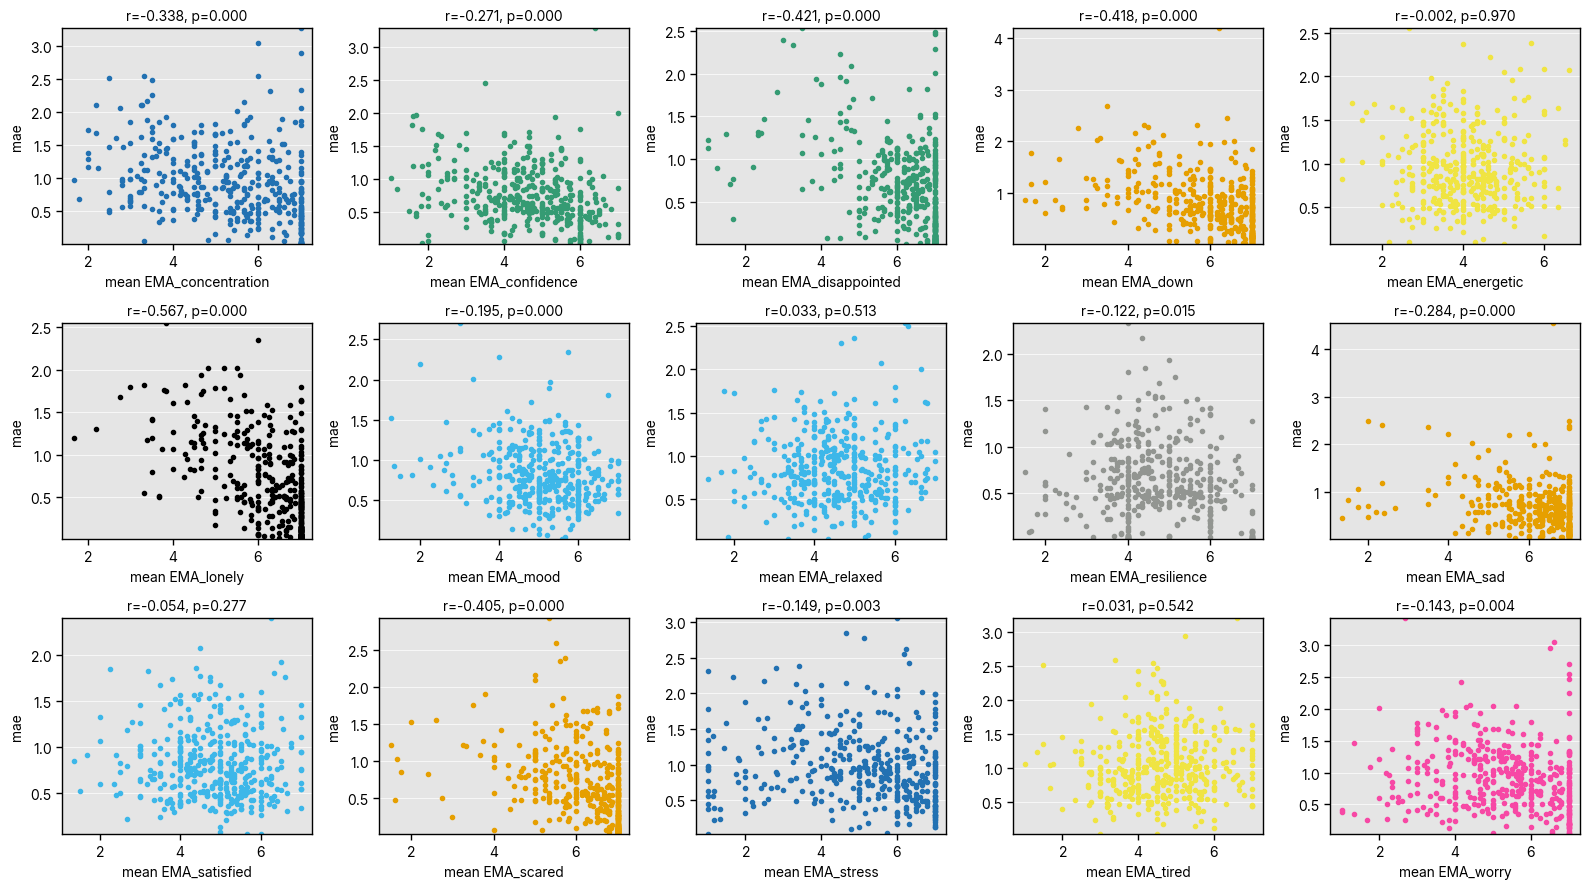

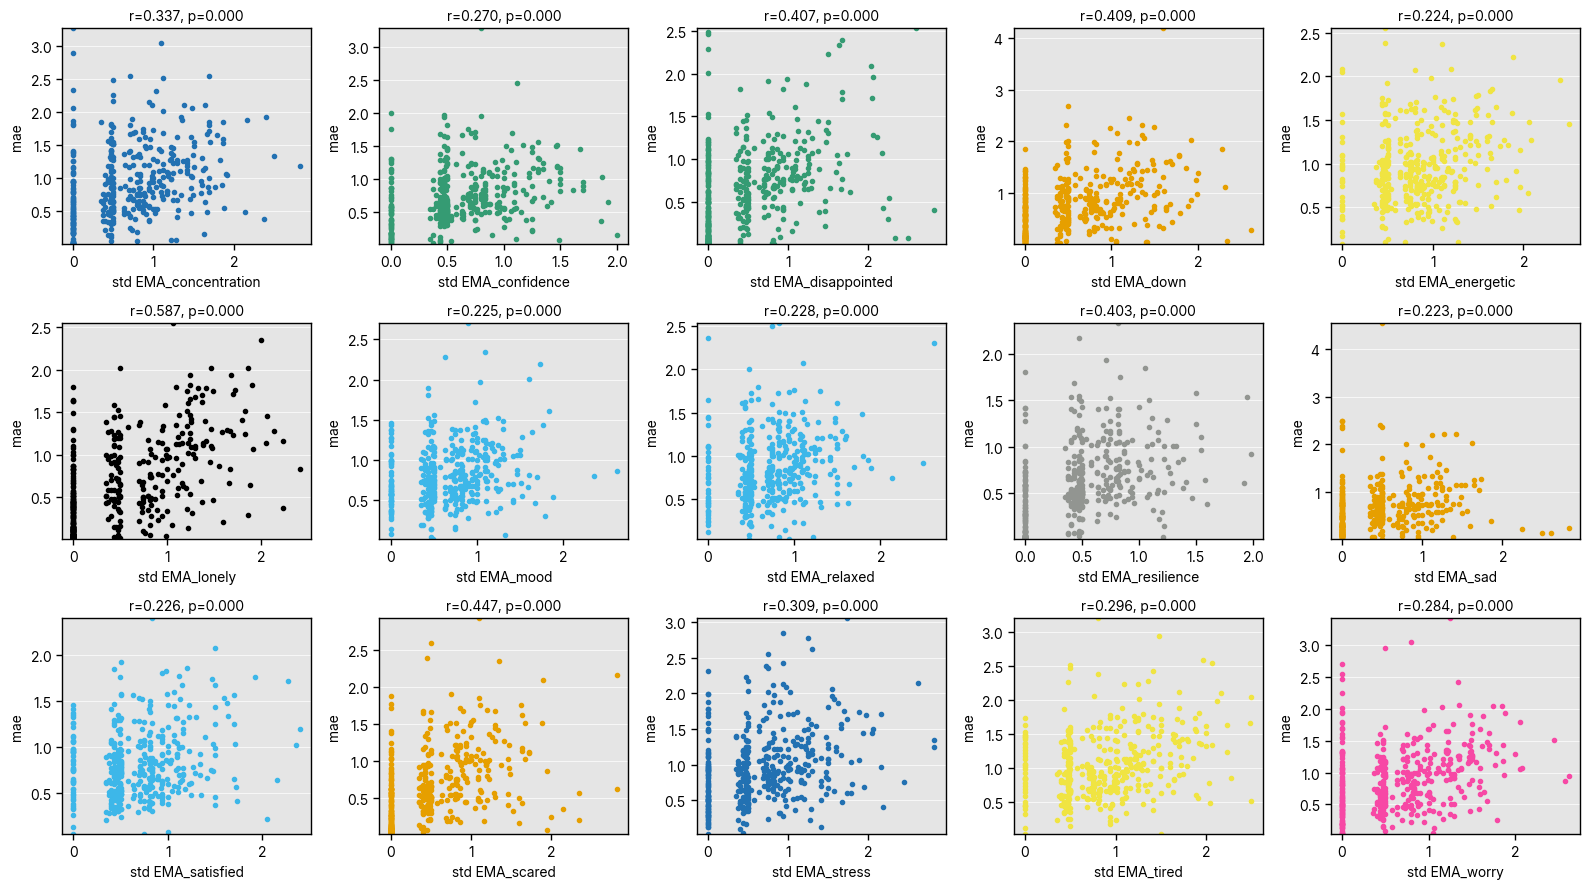

In [6]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors

mrt = 2
model = 'clipped-shallow-PLRNN'

item_means_and_var = combined_eval_file.loc[combined_eval_file['latent_model']==model].groupby(['MRT', 'latent_model', 'participant', 'feature', 'model_id'])[['gt_mean', 'gt_var']].mean()
item_names = metrics['mae'].index.get_level_values('feature').unique()

with PaperStyle():
    fig, axes = plt.subplots(3, 5, figsize=[16,9])
    axes = axes.flatten()
    idx = pd.IndexSlice

    for j, item in enumerate(item_names):
        try:
            corr = pearsonr(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_mean'].dropna(), metrics['mae'].loc[idx[mrt, model, :, item]].dropna())
        except Exception as e:
            print(e)
        else:
            r = (corr.statistic)
            p = (corr.pvalue)
            axes[j].plot(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_mean'].dropna(), metrics['mae'].loc[idx[mrt, model, :, item]].dropna(), marker='.', linestyle='', color=colors.item_color_codes([item])[0])
            axes[j].set(ylabel='mae', xlabel=f'mean {item}', title=f'r={r:.3f}, p={p:.3f}')

    plt.tight_layout()

with PaperStyle():
    fig, axes = plt.subplots(3, 5, figsize=[16,9])
    axes = axes.flatten()
    idx = pd.IndexSlice

    for j, item in enumerate(item_names):
        try:
            corr = pearsonr(np.sqrt(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_var'].dropna()), metrics['mae'].loc[idx[mrt, model, :, item]].dropna())
        except Exception as e:
            print(e)
        else:
            r = (corr.statistic)
            p = (corr.pvalue)
            axes[j].plot(np.sqrt(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_var'].dropna()), metrics['mae'].loc[idx[mrt, model, :, item]].dropna(), marker='.', linestyle='', color=colors.item_color_codes([item])[0])
            axes[j].set(ylabel='mae', xlabel=f'std {item}', title=f'r={r:.3f}, p={p:.3f}')

    plt.tight_layout()

    plt.show()

Calculate correlations between train mean, train var, gt mean and gt var and metrics across all participants and days

In [8]:
df = pd.concat((pd.DataFrame(metrics), pd.DataFrame(data_properties)), axis=1)
df.corr(method='kendall').loc[list(metrics.keys()), list(data_properties.keys())]

,train_mean,train_var,gt_mean,gt_var
mae,-0.280581,0.396590,-0.311832,0.540536
diff mae,-0.199502,0.244793,-0.266231,0.463221
change mae,-0.057235,0.172651,-0.119361,0.358473


Calculate correlations between train mean, train var, gt mean and gt var and metrics separately for each participant, then take the mean over correlation coefficients

In [7]:
import numpy as np

df = pd.concat((pd.DataFrame(metrics), pd.DataFrame(data_properties)), axis=1)
corrs = []
participants = []
for p, group in df.groupby('participant'):
    corrs.append(group.corr().loc[list(metrics.keys()), list(data_properties.keys())])
    participants.append(p)
corrs = np.tanh(np.arctanh(pd.concat(corrs, axis=0, keys=participants, names=['participant', 'metric']).unstack('metric')).mean()).unstack('metric').T
corrs

,train_mean,train_var,gt_mean,gt_var
metric,,,,
mae,-0.274842,0.411729,-0.334880,0.546287
diff mae,-0.170731,0.209162,-0.254279,0.528675
change mae,-0.040512,0.128700,-0.134797,0.503057
